In [1]:
!pip3 install git+https://github.com/am1tyadav/tfutils.git

  Cloning https://github.com/am1tyadav/tfutils.git to /tmp/pip-req-build-jf2vtvra
  Running command git clone -q https://github.com/am1tyadav/tfutils.git /tmp/pip-req-build-jf2vtvra
  Created wheel for tfutils: filename=tfutils-0.0.1-cp36-none-any.whl size=6442 sha256=e6c977d5114f852752f8533d07b2546cf662495255bac3404c8c82c5586c54ff
  Stored in directory: /tmp/pip-ephem-wheel-cache-tv4pal1j/wheels/fc/ae/41/9164f4ea031c0d70c13ba0d3fa9ab01c6783b36d6324db18ec
Successfully built tfutils


In [2]:
# import necessary packages
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
import numpy as np
import os
import tfutils
import matplotlib.pyplot as plt
from PIL import Image

print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.2.0


In [3]:
# load dataset and normalize pixel values from 0-255 using tfutils
(x_train, y_train), (x_test, y_test) = tfutils.datasets.mnist.load_data(one_hot=False)

x_train = tfutils.datasets.mnist.load_subset([0], x_train, y_train)
x_test = tfutils.datasets.mnist.load_subset([0], x_test, y_test)

x = np.concatenate([x_train, x_test], axis=0)

11493376/11490434 [==============================] - 0s 0us/step


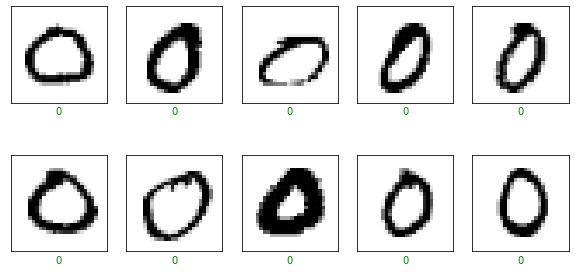

In [4]:
# plotting 10 random examples from dataset
tfutils.datasets.mnist.plot_ten_random_examples(plt, x, np.zeros((x.shape[0], 1))).show()

In [5]:
# build generator model
generatorModel = Sequential([
    Dense(256, activation='relu', input_shape=(28,)),
    Reshape((1, 1, 256)),

    Conv2DTranspose(256, 5, activation='relu'),
    BatchNormalization(),
    
    Conv2DTranspose(128, 5, activation='relu'),
    BatchNormalization(),

    Conv2DTranspose(64, 5, strides=2, activation='relu'),
    BatchNormalization(),

    Conv2DTranspose(32, 5, activation='relu'),
    BatchNormalization(),

    Conv2DTranspose(1, 4, activation='sigmoid')
  ])

generatorModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               7424      
_________________________________________________________________
reshape (Reshape)            (None, 1, 1, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 5, 5, 256)         1638656   
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 5, 256)         1024      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 9, 9, 128)         819328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 128)         512       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 21, 21, 64)        2

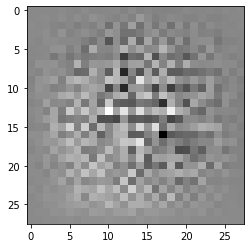

In [6]:
# check for noisy image generated by generator model
noise_image = np.random.randn(1, 28)
generator_image = generatorModel.predict(noise_image)[0]

plt.figure()
plt.imshow(np.reshape(generator_image, (28, 28)), cmap='binary')

In [7]:
# build discriminator model - cnn model to classify images
discriminatorModel = Sequential([
  Conv2D(64, 3, strides=2, input_shape=(28, 28, 1)),
  LeakyReLU(),
  BatchNormalization(),

  Conv2D(128, 5, strides=2),
  LeakyReLU(),
  BatchNormalization(),

  Conv2D(256, 5, strides=2),
  LeakyReLU(),
  BatchNormalization(),

  Flatten(),
  Dense(1, activation='sigmoid')
])

optm = tf.keras.optimizers.Adam(lr=2e-4, beta_1=0.5)
discriminatorModel.compile(loss='binary_crossentropy', optimizer=optm, metrics=['accuracy'])
discriminatorModel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 13, 13, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 13, 13, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 5, 5, 128)         0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 5, 5, 128)         512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 256)        

In [8]:
# building gan model
input_layer = tf.keras.layers.Input(shape=(28,))
generator_output = generatorModel(input_layer)
discriminator_output = discriminatorModel(generator_output)

baseModel = Model(
    input_layer,
    discriminator_output
)

discriminatorModel.trainable = False
baseModel.compile(loss='binary_crossentropy', optimizer=optm, metrics=['accuracy'])
baseModel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28)]              0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         2723937   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1027073   
Total params: 3,751,010
Trainable params: 2,722,977
Non-trainable params: 1,028,033
_________________________________________________________________


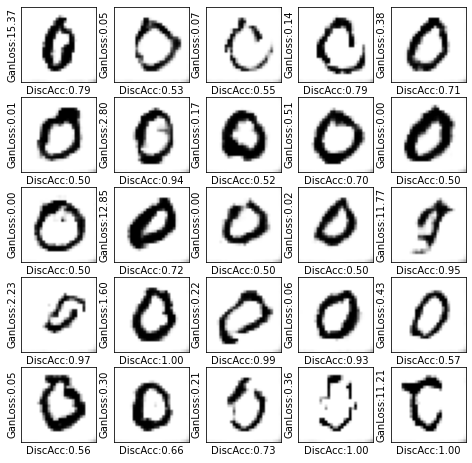

In [14]:
# train gan model
epochs = 25
batch_size = 128
steps_per_epoch = int(2 * x.shape[0]/batch_size)

plot = tfutils.plotting.DynamicPlot(plt, 5, 5, (8, 8))

for epoch in range(epochs):
  
  plot.start_of_epoch(epoch)

  for step in range(steps_per_epoch):
    true_examples = x[int(batch_size/2)*step: int(batch_size/2)*(step + 1)]
    true_examples = np.reshape(true_examples, (true_examples.shape[0], 28, 28, 1))

    noise_image = np.random.randn(int(batch_size/2), 28)
    generated_examples = generatorModel.predict(noise_image)

    x_batch = np.concatenate([generated_examples, true_examples], axis=0)
    y_batch = np.array([0] * int(batch_size/2) + [1] * int(batch_size/2))

    indices = np.random.choice(range(batch_size), batch_size, replace=False)
    x_batch = x_batch[indices]
    y_batch = y_batch[indices]

    discriminatorModel.trainable = True
    discriminatorModel.train_on_batch(x_batch, y_batch)
    discriminatorModel.trainable = False

    loss, _ = baseModel.train_on_batch(noise_image, np.ones((int(batch_size/2), 1)))
    _, acc = discriminatorModel.evaluate(x_batch, y_batch, verbose=False)

  noise_image = np.random.randn(1, 28)
  generated_example = generatorModel.predict(noise_image)[0]

  plot.end_of_epoch(np.reshape(generated_example, (28, 28)), 'binary', 'DiscAcc:{:.2f}'.format(acc), 'GanLoss:{:.2f}'.format(loss))